In [1]:
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Patch
import matplotlib.patches as patches
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM
import scipy.stats as stats
from scipy.stats import spearmanr
from sklearn.utils import resample
from statsmodels.stats.power import GofChisquarePower
from scipy.stats import norm
from scipy.stats import wilcoxon

# Extract data from firebase

In [2]:
# Function to convert trials data to DataFrame
def trials_to_dataframe_new(data_list, phase_key):
    all_trials = []
    trial_numbers = set()  # To keep track of unique trial numbers

    for item in data_list:
        if phase_key in item:
            print(f"Found phase key: {phase_key}")
            phase_data = item[phase_key]
            # Check if dataIncomplete exists
            if 'dataIncomplete' in phase_data and 'fields' in phase_data['dataIncomplete'] and 'trials' in phase_data['dataIncomplete']['fields']:
                print(f"Using dataIncomplete for {phase_key}")
                trials = phase_data['dataIncomplete']['fields']['trials']
                for trial in trials:
                    trial_number = trial.get('trialNumber')
                    if trial_number not in trial_numbers:
                        all_trials.append(trial)
                        trial_numbers.add(trial_number)
                break  # Skip processing batches if dataIncomplete is found

            for batch_key in phase_data:
                print(f"Processing {batch_key}")
                batch_data = phase_data[batch_key]
                if 'fields' in batch_data and 'trials' in batch_data['fields']:
                    trials = batch_data['fields']['trials']
                    for trial in trials:
                        trial_number = trial.get('trialNumber')
                        # Only add the trial if it hasn't been added before
                        if trial_number not in trial_numbers:
                            all_trials.append(trial)
                            trial_numbers.add(trial_number)
                        else: 
                            print("there's a duplicate trial")

    if all_trials:
        return pd.DataFrame(all_trials)
    else:
        return None

In [3]:
# Create list of dictionaries for subjects
subjects = []

In [4]:
# for the pilot study I need to combine the data in raw data from pilot study 2 and pilot study 2  suite
# Directory containing the JSON files
directory = '/Users/jadeserfaty/Library/Mobile Documents/com~apple~CloudDocs/code/lido/introspection_task/public/data/raw/tasks/'

In [5]:
# Process each JSON file
for filename in os.listdir(directory):
    if "json" in filename:
        print(filename)
        # Create DataFrames for each phase
        dfs = {}
        if filename.endswith('.json'):
            file_path = os.path.join(directory, filename)
            with open(file_path, 'r') as file:
                subject_data_list = json.load(file)
                setupData = pd.DataFrame([subject_data_list[0]["fields"]])
                setupData["id"] = subject_data_list[0]["id"]
                dfs["setupData"] = setupData
                print(subject_data_list[0]["id"])
            for phase_key in ['browser_checks', 'emotionDiscriminationPhase', 'ratingPhase1', 'ratingPhase2', 'viewingPhase']:
                df = trials_to_dataframe_new(subject_data_list, phase_key)
                if df is not None:
                    if phase_key not in dfs:
                        dfs[phase_key] = df
                    else:
                        dfs[phase_key] = pd.concat([dfs[phase_key], df], ignore_index=True)
                else:
                    print(f"No data loaded for {phase_key} in file {filename}")

        subjects.append(dfs)


# Example to print out one of the DataFrames
if 'browser_checks' in dfs:
    print("DataFrame for browser_checks:")
    print(dfs['browser_checks'])
else:
    print("No data found for browser_checks")

0.json
LhCpZNJ8jGbt36bT2wJdFzeNSEO2
Found phase key: browser_checks
Processing data
No data loaded for emotionDiscriminationPhase in file 0.json
No data loaded for ratingPhase1 in file 0.json
No data loaded for ratingPhase2 in file 0.json
No data loaded for viewingPhase in file 0.json
1.json
oSLrRv2A4tY3W9shdteHa9dr67l2
Found phase key: browser_checks
Processing data
No data loaded for emotionDiscriminationPhase in file 1.json
Found phase key: ratingPhase1
Processing batch_0
Processing batch_1
there's a duplicate trial
Processing batch_2
there's a duplicate trial
Processing batch_3
there's a duplicate trial
Processing batch_4
there's a duplicate trial
Found phase key: ratingPhase2
Processing batch_0
Processing batch_1
there's a duplicate trial
Processing batch_2
there's a duplicate trial
Processing batch_3
there's a duplicate trial
Processing batch_4
there's a duplicate trial
Found phase key: viewingPhase
Processing batch_0
Processing batch_1
there's a duplicate trial
Processing batch_

# Check participant's timings

In [8]:
firebaseIDFocus = "oSLrRv2A4tY3W9shdteHa9dr67l2"
prolific_ids = []
# DEFINE SUBJECT OF FOCUS HERE
for subject in range(len(subjects)): 
    if "subjectID_prolific" in subjects[subject]['setupData'].keys():
        prolific_ids.append(subjects[subject]['setupData']["subjectID_prolific"].iloc[0])
        if subjects[subject]['setupData']["uid_firebase"].iloc[0] == firebaseIDFocus:
            print("the subject index is: " + str(subject))
            if subjects[subject]['setupData']["completed"].iloc[0] == 1: 
                print("it's completed")
            else: 
                print("it's NOT completed")
            subjectFocus = subjects[subject]

#     if len(prolific_ids) != len(np.unique(prolific_ids)):
#         print("ATTENTION one or more participant did the study more than once!")
#     else: 
#         print("all participants are unique!")

the subject index is: 1
it's completed


In [9]:
duration_viewing_phase_ms = subjectFocus["viewingPhase"]["time_elapsed"][len(subjectFocus["viewingPhase"]["time_elapsed"])-1] - subjectFocus["viewingPhase"]["time_elapsed"].iloc[0]
duration_viewing_phase_min = duration_viewing_phase_ms/1000/60
print("the viewing phase lasts: " + str(duration_viewing_phase_min) + " minutes.")

the viewing phase lasts: 17.376766666666665 minutes.


In [10]:
if len(subjectFocus["ratingPhase1"]) !=0:
    duration_rating_phase1_ms = subjectFocus["ratingPhase1"]["time_elapsed"][len(subjectFocus["ratingPhase1"]["time_elapsed"])-1] - subjectFocus["ratingPhase1"]["time_elapsed"][0]
    duration_rating_phase1_min = duration_rating_phase1_ms/1000/60
    print("the rating phase 1 lasts: " + str(duration_rating_phase1_min) + " minutes.")

the rating phase 1 lasts: 18.4667 minutes.


In [11]:
if len(subjectFocus["ratingPhase2"]) !=0: 
    duration_rating_phase2_ms = subjectFocus["ratingPhase2"]["time_elapsed"][len(subjectFocus["ratingPhase2"]["time_elapsed"])-1] - subjectFocus["ratingPhase2"]["time_elapsed"][0]
    duration_rating_phase2_min = duration_rating_phase2_ms/1000/60
    print("the rating phase 2 lasts: " + str(duration_rating_phase2_min) + " minutes.")

the rating phase 2 lasts: 18.255816666666664 minutes.


# Filter participants who completed

In [12]:
participants_completed = []

In [16]:
for subject in range(len(subjects)): 
    if "completed" in subjects[subject]["setupData"].columns:
        if subjects[subject]['setupData']["completed"].iloc[0] == 1: 
            if "ratingPhase1" in subjects[subject].keys():
                participants_completed.append(subject)
           

In [17]:
participants_completed

[1]

## check number of trials in each phase

In [18]:
for subject in participants_completed: 
    viewing_phase = subjects[subject]["viewingPhase"]
    length_viewing = viewing_phase[viewing_phase["trial_type"]=="videoViewingTask"]
    length_attention = viewing_phase[viewing_phase["trial_type"]=="attentionCheckTask"]
    print(len(length_viewing))
    print(len(length_attention))
    
    rating_phase1 = subjects[subject]["ratingPhase1"]
    print(len(rating_phase1))
    rating_phase2 = subjects[subject]["ratingPhase2"]
    print(len(rating_phase2))

142
35
142
142


# check order of viewing phase

0    oSLrRv2A4tY3W9shdteHa9dr67l2
Name: uid_firebase, dtype: object


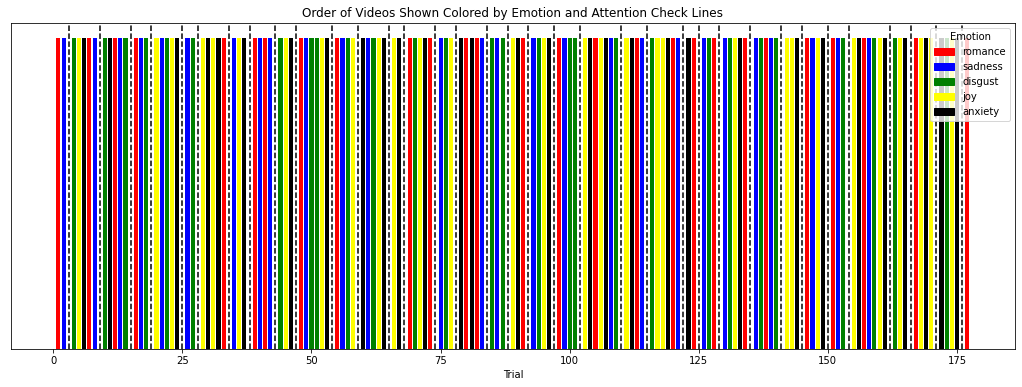

In [19]:
for subject in participants_completed:
    subjectFocus = subjects[subject]
    print(subjectFocus["setupData"]["uid_firebase"])
    dist_check_table = subjectFocus["viewingPhase"][["videoId", "trialNumber","intensityBin", "trial_type","emotionName"]]
    # Plot for emotionName with attention check lines
    plt.figure(figsize=(18, 6))

    # Lists to store legend handles and labels
    legend_handles = []
    legend_labels = []

    # Loop through each row in the DataFrame
    for index, row in dist_check_table.iterrows():
        trial_number = row['trialNumber']
        emotion = row['emotionName']
        if row['trial_type'] == 'attentionCheckTask':
            # Draw a black dashed line for attention check trials
            plt.axvline(x=trial_number, color='black', linestyle='--')
        else:
            # Plot a colored dot for regular trials
            color = 'red' if emotion == 'romance' else 'blue' if emotion == 'sadness' else 'green' if emotion == 'disgust' else 'yellow' if emotion == 'joy' else 'black'
            plt.bar(trial_number, 1, color=color, width=0.8)  # Set width to 0.8 for thinner bars

            # Add the handle and label for the legend
            if emotion not in legend_labels:
                legend_handles.append(Patch(color=color))
                legend_labels.append(emotion)

    # Add legend
    plt.legend(legend_handles, legend_labels, title='Emotion')

    plt.xlabel('Trial')
    plt.yticks([])  # Hide y-axis ticks and labels
    plt.title('Order of Videos Shown Colored by Emotion and Attention Check Lines')
    plt.show()

0    oSLrRv2A4tY3W9shdteHa9dr67l2
Name: uid_firebase, dtype: object


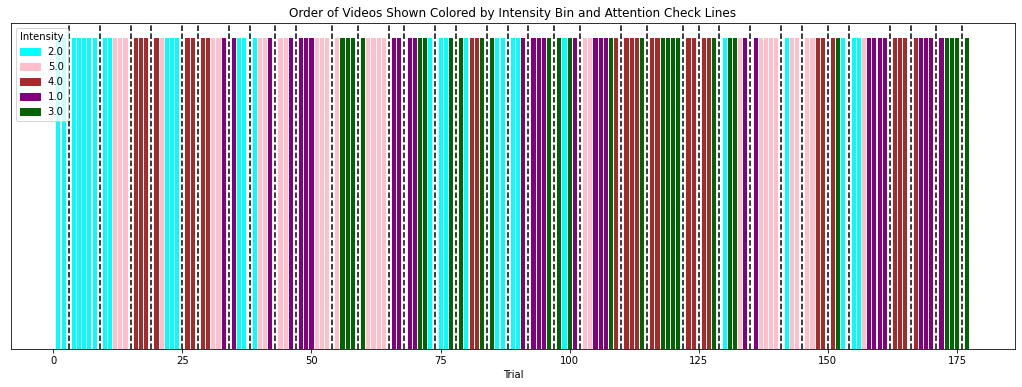

In [20]:
for subject in participants_completed:
    subjectFocus = subjects[subject]
    print(subjectFocus["setupData"]["uid_firebase"])
    dist_check_table = subjectFocus["viewingPhase"][["videoId", "trialNumber","intensityBin", "trial_type","emotionName"]]
 
    # Plot for emotionName with attention check lines
    plt.figure(figsize=(18, 6))

    # Lists to store legend handles and labels
    legend_handles = []
    legend_labels = []

    # Loop through each row in the DataFrame
    for index, row in dist_check_table.iterrows():
        trial_number = row['trialNumber']
        intensityBin = row['intensityBin']
        if row['trial_type'] == 'attentionCheckTask':
            # Draw a black dashed line for attention check trials
            plt.axvline(x=trial_number, color='black', linestyle='--')
        else:
            # Plot a colored dot for regular trials
            color = 'purple' if intensityBin == 1 else 'cyan' if intensityBin == 2 else 'darkgreen' if intensityBin == 3 else 'brown' if intensityBin == 4 else 'pink'
            plt.bar(trial_number, 1, color=color, width=0.8)  # Set width to 0.8 for thinner bars

            # Add the handle and label for the legend
            if intensityBin not in legend_labels:
                legend_handles.append(Patch(color=color))
                legend_labels.append(intensityBin)

    # Add legend
    plt.legend(legend_handles, legend_labels, title='Intensity')

    plt.xlabel('Trial')
    plt.yticks([])  # Hide y-axis ticks and labels
    plt.title('Order of Videos Shown Colored by Intensity Bin and Attention Check Lines')
    plt.show()


In [21]:
for subject in participants_completed:
    subjectFocus = subjects[subject]
    print(subjectFocus["setupData"]["uid_firebase"])
    dist_check_table = subjectFocus["viewingPhase"][["videoId", "trialNumber","intensityBin", "trial_type","emotionName"]]
    print(dist_check_table.head())

0    oSLrRv2A4tY3W9shdteHa9dr67l2
Name: uid_firebase, dtype: object
  videoId  trialNumber  intensityBin          trial_type emotionName
0    1086            1           2.0    videoViewingTask     romance
1    1725            2           2.0    videoViewingTask     sadness
2     NaN            3           NaN  attentionCheckTask         NaN
3    1137            4           2.0    videoViewingTask     disgust
4    1012            5           2.0    videoViewingTask         joy


# check order of rating phases

1


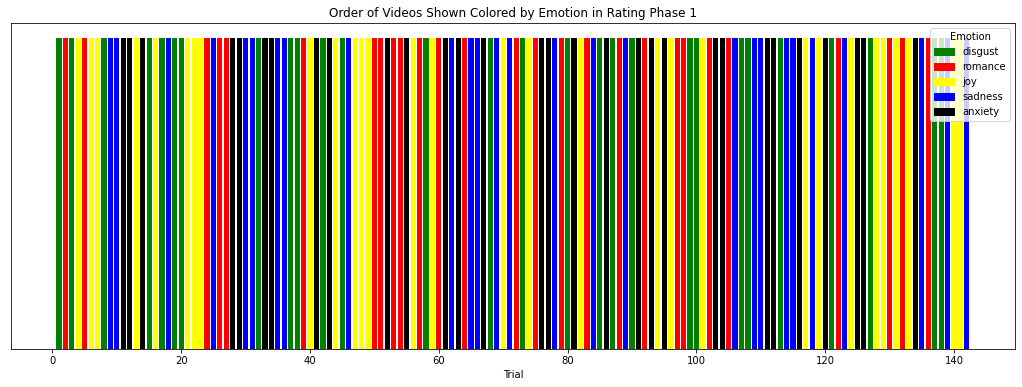

In [22]:
for subject in participants_completed:
    subjectFocus = subjects[subject]
    print(subject)
    dist_check_table = subjectFocus["ratingPhase1"][["videoID", "trialNumber","emotionName"]]
    # Plot for emotionName with attention check lines
    plt.figure(figsize=(18, 6))

    # Lists to store legend handles and labels
    legend_handles = []
    legend_labels = []

    # Loop through each row in the DataFrame
    for index, row in dist_check_table.iterrows():
        trial_number = row['trialNumber']
        emotion = row['emotionName']
    
        # Plot a colored dot for regular trials
        color = 'red' if emotion == 'romance' else 'blue' if emotion == 'sadness' else 'green' if emotion == 'disgust' else 'yellow' if emotion == 'joy' else 'black'
        plt.bar(trial_number, 1, color=color, width=0.8)  # Set width to 0.8 for thinner bars

        # Add the handle and label for the legend
        if emotion not in legend_labels:
            legend_handles.append(Patch(color=color))
            legend_labels.append(emotion)

    # Add legend
    plt.legend(legend_handles, legend_labels, title='Emotion')

    plt.xlabel('Trial')
    plt.yticks([])  # Hide y-axis ticks and labels
    plt.title('Order of Videos Shown Colored by Emotion in Rating Phase 1')
    plt.show()

1


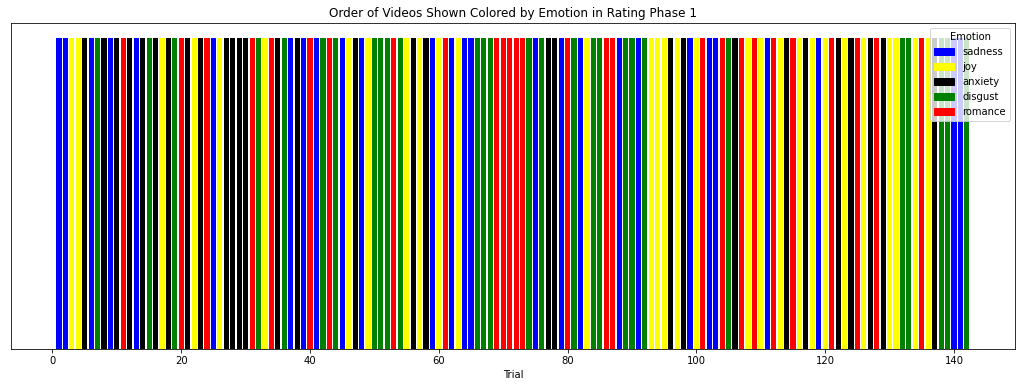

In [23]:
for subject in participants_completed:
    subjectFocus = subjects[subject]
    print(subject)
    dist_check_table = subjectFocus["ratingPhase2"][["videoID", "trialNumber","emotionName"]]
    # Plot for emotionName with attention check lines
    plt.figure(figsize=(18, 6))

    # Lists to store legend handles and labels
    legend_handles = []
    legend_labels = []

    # Loop through each row in the DataFrame
    for index, row in dist_check_table.iterrows():
        trial_number = row['trialNumber']
        emotion = row['emotionName']
    
        # Plot a colored dot for regular trials
        color = 'red' if emotion == 'romance' else 'blue' if emotion == 'sadness' else 'green' if emotion == 'disgust' else 'yellow' if emotion == 'joy' else 'black'
        plt.bar(trial_number, 1, color=color, width=0.8)  # Set width to 0.8 for thinner bars

        # Add the handle and label for the legend
        if emotion not in legend_labels:
            legend_handles.append(Patch(color=color))
            legend_labels.append(emotion)

    # Add legend
    plt.legend(legend_handles, legend_labels, title='Emotion')

    plt.xlabel('Trial')
    plt.yticks([])  # Hide y-axis ticks and labels
    plt.title('Order of Videos Shown Colored by Emotion in Rating Phase 1')
    plt.show()


# Check videos long and short in rating phases 1 and 2

In [24]:
# Check if half of the rows in each phase have a duration of 900 and 2600
def check_half_rows(df):
    half_rows = len(df) // 2
    count_900 = df[df['durationBlackScreen'] == 900]['durationBlackScreen'].count()
    count_2600 = df[df['durationBlackScreen'] == 2600]['durationBlackScreen'].count()
    return count_900, count_2600 

In [25]:
# Check if each row has different durations in the two phases
def check_different_durations(df):
    return (df['durationBlackScreen_phase1'] != df['durationBlackScreen_phase2']).all()

In [26]:
for subject in participants_completed:
    subjectFocus = subjects[subject]
    print(subjectFocus["setupData"]["uid_firebase"])
    two_rating_phases = pd.merge(subjectFocus["ratingPhase1"][["videoID", "durationBlackScreen"]],
                     subjectFocus["ratingPhase2"][["videoID", "durationBlackScreen"]],
                     on='videoID',
                     suffixes=('_phase1', '_phase2'))
    phase1_count_900, phase1_count_2600 = check_half_rows(subjectFocus["ratingPhase1"])
    phase2_count_900, phase2_count_2600 = check_half_rows(subjectFocus["ratingPhase2"])

    print(f"In phase 1, {phase1_count_900} video have a duration 900ms and {phase1_count_2600} have a duration 2600ms.")
    print(f"In phase 2, {phase2_count_900} video have a duration 900ms and {phase2_count_2600} have a duration 2600ms.")
    
    different_durations = check_different_durations(two_rating_phases)

    print("Each row has different durations in the two phases:", different_durations)

0    oSLrRv2A4tY3W9shdteHa9dr67l2
Name: uid_firebase, dtype: object
In phase 1, 70 video have a duration 900ms and 72 have a duration 2600ms.
In phase 2, 72 video have a duration 900ms and 70 have a duration 2600ms.
Each row has different durations in the two phases: True


# Check if the durations of ratings are actually 900 and 2600 ms

In [28]:
tolerance = 50
for subject in participants_completed:
    subjectFocus = subjects[subject]
    phase_1_durations = subjectFocus["ratingPhase1"][["timeSnapshotAppears", 'timeSnapshotDisappears', "durationBlackScreen"]].copy()
    phase_2_durations = subjectFocus["ratingPhase2"][["timeSnapshotAppears", 'timeSnapshotDisappears', "durationBlackScreen"]].copy()
    phase_1_durations.loc[:, "actual_duration"] = phase_1_durations["timeSnapshotDisappears"] - phase_1_durations["timeSnapshotAppears"]
    phase_2_durations.loc[:, 'actual_duration'] = phase_2_durations["timeSnapshotDisappears"] - phase_2_durations["timeSnapshotAppears"]
    # Check if the difference is within the tolerance
    phase_1_durations.loc[:, "actualVsexpected"] = abs(phase_1_durations["actual_duration"] - phase_1_durations["durationBlackScreen"]) <= tolerance
    phase_2_durations.loc[:, 'actualVsexpected'] = abs(phase_2_durations["actual_duration"] - phase_2_durations["durationBlackScreen"]) <= tolerance
    
    # Print the rows where the actual duration is not within the expected range
    print(phase_1_durations[phase_1_durations["actualVsexpected"] == False])
    print(phase_2_durations[phase_2_durations["actualVsexpected"] == False])

    timeSnapshotAppears  timeSnapshotDisappears  durationBlackScreen  \
38            1449645.3               1452656.9                 2600   
44            1501662.5               1504656.2                 2600   
46            1518578.4               1521657.6                 2600   
58            1619657.8               1620657.4                  900   

    actual_duration  actualVsexpected  
38           3011.6             False  
44           2993.7             False  
46           3079.2             False  
58            999.6             False  
Empty DataFrame
Columns: [timeSnapshotAppears, timeSnapshotDisappears, durationBlackScreen, actual_duration, actualVsexpected]
Index: []
